In [1]:

from datascience import *
path_data = '../../../../data/'
import numpy as np
from scipy import stats

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# HIDDEN 

galton = Table.read_table(path_data + 'galton.csv')
heights = galton.select('midparentHeight', 'childHeight')
heights = heights.relabel(0, 'MidParent').relabel(1, 'Child')
dugong = Table.read_table(path_data + 'dugongs.csv')
dugong = dugong.move_to_start('Length')
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [3]:

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)
    
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)   

In [4]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )

### Numerical Diagnostics ###

In addition to visualization, we can use numerical properties of residuals to assess the quality of regression. We will not prove these properties mathematically. Rather, we will observe them by computation and see what they tell us about the regression.

All of the facts listed below hold for all shapes of scatter plots, whether or not they are linear.

### Residual Plots Show No Trend ###
**For every linear regression, whether good or bad, the residual plot shows no trend. Overall, it is flat. In other words, the residuals and the predictor variable are uncorrelated.** 

You can see this in all the residual plots above. We can also calculate the correlation between the predictor variable and the residuals in each case.



In [5]:
correlation(heights, 'MidParent', 'Residual')

-2.719689807647064e-16

That doesn't look like zero, but it is a tiny number that is 0 apart from rounding error due to computation. Here it is again, correct to 10 decimal places. The minus sign is because of the rounding that above.

In [6]:
round(correlation(heights, 'MidParent', 'Residual'), 10)

-0.0

In [7]:
dugong = dugong.with_columns(
       'Fitted Value', fit(dugong, 'Length', 'Age'),
       'Residual', residual(dugong, 'Length', 'Age')
)
round(correlation(dugong, 'Length', 'Residual'), 10)

0.0

### Average of Residuals ###
**No matter what the shape of the scatter diagram, the average of the residuals is 0.**

This is analogous to the fact that if you take any list of numbers and calculate the list of deviations from average, the average of the deviations is 0.

In all the residual plots above, you have seen the horizontal line at 0 going through the center of the plot. That is a visualization of this fact.

As a numerical example, here is the average of the residuals in the regression of children's heights based on parents' heights in Galton's dataset.

In [8]:
round(np.mean(heights.column('Residual')), 10)

0.0

The same is true of the average of the residuals in the regression of the age of dugongs on their length. The mean of the residuals is 0, apart from rounding error. 

In [9]:
round(np.mean(dugong.column('Residual')), 10)

0.0

### SD of the Residuals ###
**No matter what the shape of the scatter plot, the SD of the residuals is a fraction of the SD of the response variable. The fraction is  $\sqrt{1-r^2}$.**

$$
\mbox{SD of residuals} ~=~ \sqrt{1 - r^2} \cdot \mbox{SD of }y
$$

We will soon see how this measures the accuracy of the regression estimate. But first, let's confirm it by example. 

In the case of children's heights and midparent heights, the SD of the residuals is about 3.39 inches.

In [10]:
np.std(heights.column('Residual'))

3.3880799163953426

That's the same as $\sqrt{1-r^2}$ times the SD of response variable: 

In [11]:
r = correlation(heights, 'MidParent', 'Child')
np.sqrt(1 - r**2) * np.std(heights.column('Child'))

3.388079916395342

The same is true for the regression of mileage on acceleration of hybrid cars. The correlation $r$ is negative (about -0.5), but $r^2$ is positive and therefore $\sqrt{1-r^2}$ is a fraction.

In [12]:
r = correlation(hybrid, 'acceleration', 'mpg')
r

-0.5060703843771186

In [13]:
hybrid = hybrid.with_columns(
     'fitted mpg', fit(hybrid, 'acceleration', 'mpg'),
     'residual', residual(hybrid, 'acceleration', 'mpg')
)
np.std(hybrid.column('residual')), np.sqrt(1 - r**2)*np.std(hybrid.column('mpg'))

(9.43273683343029, 9.43273683343029)

Now let us see how the SD of the residuals is a measure of how good the regression is. Remember that the average of the residuals is 0. Therefore the smaller the SD of the residuals is, the closer the residuals are to 0. In other words, if the SD of the residuals is small, the overall size of the errors in regression is small.

The extreme cases are when $r=1$ or $r=-1$. In both cases, $\sqrt{1-r^2} = 0$. Therefore the residuals have an average of 0 and an SD of 0 as well, and therefore the residuals are all equal to 0. The regression line does a perfect job of estimation. As we saw earlier in this chapter, if $r = \pm 1$, the scatter plot is a perfect straight line and is the same as the regression line, so indeed there is no error in the regression estimate. 

But usually $r$ is not at the extremes. If $r$ is neither $\pm 1$ nor 0, then $\sqrt{1-r^2}$ is a proper fraction, and the rough overall size of the error of the regression estimate is somewhere between 0 and the SD of $y$.

The worst case is when $r = 0$. Then $\sqrt{1-r^2} =1$, and the SD of the residuals is equal to the SD of $y$. This is consistent with the observation that if $r=0$ then the regression line is a flat line at the average of $y$. In this situation, the root mean square error of regression is the root mean squared deviation from the average of $y$, which is the SD of $y$. In practical terms, if $r = 0$ then there is no linear association between the two variables, so there is no benefit in using linear regression.

### Another Way to Interpret $r$ ###
We can rewrite the result above to say that no matter what the shape of the scatter plot,

$$
\frac{\mbox{SD of residuals}}{\mbox{SD of }y} ~=~ \sqrt{1-r^2}
$$

A complementary result is that no matter what the shape of the scatter plot, the SD of the fitted values is a fraction of the SD of the observed values of $y$. The fraction is $\vert r \vert$.

$$
\frac{\mbox{SD of fitted values}}{\mbox{SD of }y} ~=~ \vert r \vert
$$

To see where the fraction comes in, notice that the fitted values are all on the regression line whereas the observed values of $y$ are the heights of all the points in the scatter plot and are more variable.

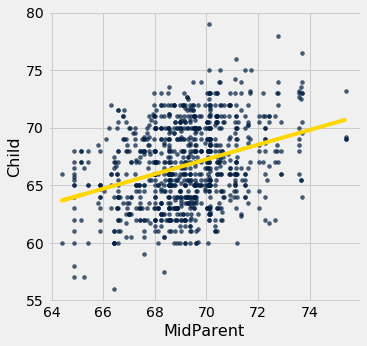

In [14]:
scatter_fit(heights, 'MidParent', 'Child')

The fitted values range from about 64 to about 71, whereas the heights of all the children are quite a bit more variable, ranging from about 55 to 80.

To verify the result numerically, we just have to calculate both sides of the identity.

In [15]:
correlation(heights, 'MidParent', 'Child')

0.32094989606395924

Here is ratio of the SD of the fitted values and the SD of the observed values of birth weight:

In [16]:
np.std(heights.column('Fitted Value'))/np.std(heights.column('Child'))

0.32094989606395957

The ratio is equal to $r$, confirming our result.

Where does the absolute value come in? First note that as SDs can't be negative, nor can a ratio of SDs. So what happens when $r$ is negative? The example of fuel efficiency and acceleration will show us.

In [17]:
correlation(hybrid, 'acceleration', 'mpg')

-0.5060703843771186

In [18]:
np.std(hybrid.column('fitted mpg'))/np.std(hybrid.column('mpg'))

0.5060703843771186

The ratio of the two SDs is $\vert r \vert$. 

A more standard way to express this result is to recall that 

$$
\mbox{variance} ~=~ \mbox{mean squared deviation from average} ~=~ \mbox{SD}^2
$$

and therefore, by squaring both sides of our result,

$$
\frac{\mbox{variance of fitted values}}{\mbox{variance of }y} ~=~ r^2
$$